In [19]:
# std
import os
from os import path
import time

# 3p
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# prj
os.chdir("..")
from src import helpers, configuration, filtering, bandpower, plots, statistics as stats
from src.configuration import cfg
os.chdir('analysis-adelie')

# statistics
from scipy.stats import ttest_ind

import mne
from mne import viz

# plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib

font = {'family':'DejaVu Sans', 'weight':'normal', 'size':15}
matplotlib.rc('font', **font)

%matplotlib qt

### General

In [20]:
def get_channelsList(config, subject='adelie'):
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    file_path = f"{base_path}/{subject_paths['prefix']}/offline/fif/{subject_paths['channels_path']}"
    with open(file_path, 'r') as channels_file:
        all_channels = channels_file.read().strip()
    return [channel for channel in all_channels.split('\n') if channel not in config['columns_to_remove']]

events = None
def load_raw_mne_from_fif(data_type, subject='adelie', recording=0, montage='standard_1020', config=cfg):
    global events
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    recording_id = helpers.get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    events = mne.find_events(raw)

    # Create info with some useful information
    info = mne.create_info(get_channelsList(config), sfreq=config['sampling_frequency'], ch_types='eeg')
    raw.info = info
    
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=True)
    raw.set_eeg_reference('average', projection=True)#.apply_proj()
    
    return raw

In [21]:
def normalise_layout_pos(layout):
    _t = layout.pos[:, :2]
    _t -= np.mean(_t, 0)
    _t /= np.max(_t, 0)
    
    return _t

### Dynamics: maps over epochs

In [4]:
signals = load_raw_mne_from_fif('baseline', subject='sam', config=cfg)
layout = mne.channels.make_eeg_layout(signals.info)
normalised_pos = normalise_layout_pos(layout)

Opening raw data file C:/Users/adeli/OneDrive/Documents/GitHub/data/AlphaTheta/sam-AlphaTheta/offline/fif/baseline11-raw.fif...
Isotrak not found
    Range : 0 ... 38030 =      0.000 ...   126.767 secs
Ready.
Reading 0 ... 38030  =      0.000 ...   126.767 secs...
2 events found
Event IDs: [15 16]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Text(0.5, 0.98, 'Dynamics of Alpha / Theta')

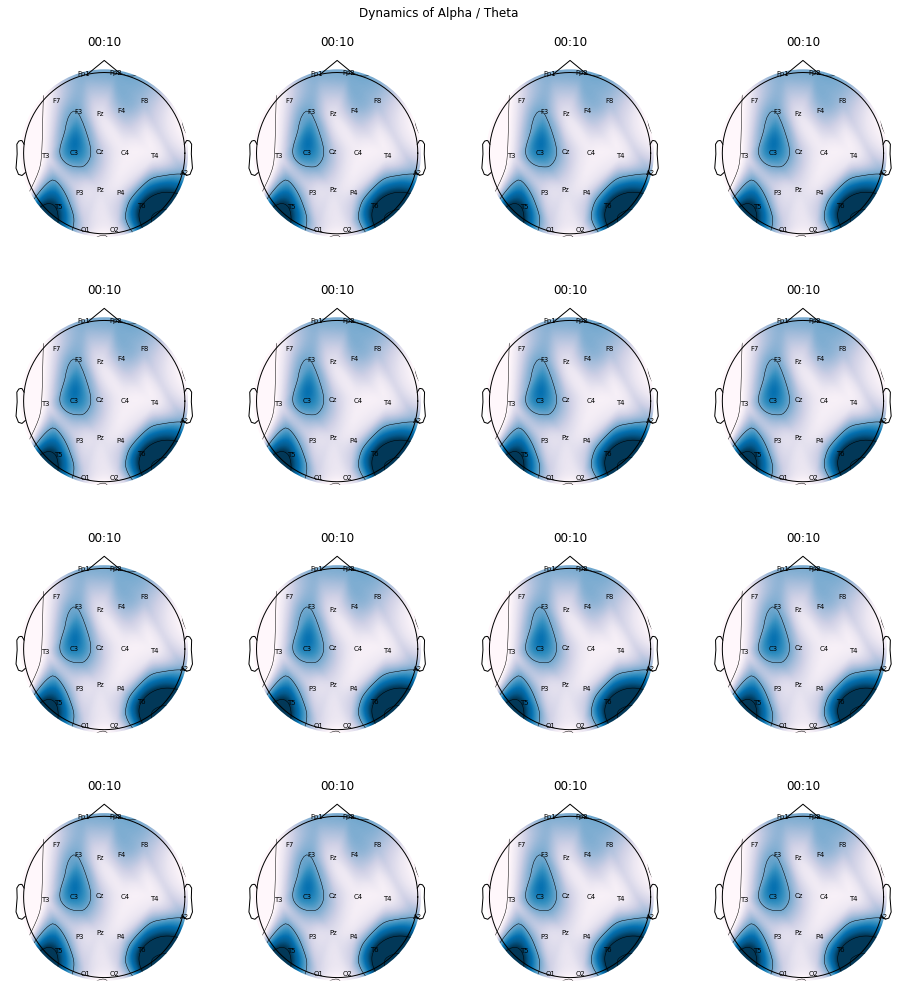

In [17]:
h_adelie = pd.read_csv('test_sam_mind_map.csv', delimiter=';')
h_adelie = h_adelie.rename(columns={'Unnamed: 0': 'ti'})
n_subplots = 16
fig, axs = plt.subplots(nrows=4, ncols=n_subplots // 4, figsize=(16, 16))
time_idx_to_plot = np.linspace(0, h_adelie.shape[0] - 1, num=16, dtype='int')
flattened_axs = [item for sublist in axs for item in sublist]
electrodes = [c for c in h_adelie.columns if c not in ['ti']]
for plt_idx, time_idx in enumerate(time_idx_to_plot):
    viz.plot_topomap(h_adelie.loc[time_idx][electrodes].T.values,
                     cmap='PuBu',
                     sphere=1.,
                     pos=normalised_pos,
                     axes=flattened_axs[plt_idx],
                     sensors=False,
                     show_names=True,
                     show=False,
                     names=electrodes)
    flattened_axs[plt_idx].set_title(h_adelie.at[time_idx, 'ti'][3:8])
fig.suptitle('Dynamics of Alpha / Theta')

### Predefined metrics: ratio meditation/baseline

In [23]:
cmap='PuBu'

#### Theta

In [92]:
# set the same color scale for all subjects
vmin_t = min(min(data_ad_t.loc[0][electrodes].T.values), 
             min(data_sam_t.loc[0][electrodes].T.values),
             min(data_rap_t.loc[0][electrodes].T.values),
             min(data_sam2_t.loc[0][electrodes].T.values))

vmax_t = max(max(data_ad_t.loc[0][electrodes].T.values), 
             max(data_sam_t.loc[0][electrodes].T.values),
             max(data_rap_t.loc[0][electrodes].T.values),
             max(data_sam2_t.loc[0][electrodes].T.values))

In [93]:
data_ad_t = pd.read_csv('ratio_theta_adelie.csv')
data_ad_t = data_ad_t.rename(columns={'Unnamed: 0': 'ti'})

electrodes = [c for c in data_ad_t.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_t, vmax=vmax_t)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

viz.plot_topomap(data_ad_t.loc[0][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_t, vmax=vmax_t,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Theta band | Adélie')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [94]:
data_sam_t = pd.read_csv('ratio_theta_sam.csv')
data_sam_t = data_sam_t.rename(columns={'Unnamed: 0': 'ti'})

electrodes = [c for c in data_sam_t.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_t, vmax=vmax_t)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

viz.plot_topomap(data_sam_t.loc[0][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_t, vmax=vmax_t,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Theta band | Sam')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [95]:
data_sam2_t = pd.read_csv('ratio_theta_sam2.csv')
data_sam2_t = data_sam2_t.rename(columns={'Unnamed: 0': 'ti'})

electrodes = [c for c in data_sam2_t.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_t, vmax=vmax_t)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

viz.plot_topomap(data_sam2_t.loc[0][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_t, vmax=vmax_t,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Theta band | Sam2')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [96]:
data_rap_t = pd.read_csv('ratio_theta_rap.csv')
data_rap_t = data_rap_t.rename(columns={'Unnamed: 0': 'ti'})

electrodes = [c for c in data_rap_t.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_t, vmax=vmax_t)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

viz.plot_topomap(data_rap_t.loc[0][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_t, vmax=vmax_t,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Theta band | Raphaël')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

Four figures in one

In [152]:
electrodes = [c for c in data_ad_t.columns if c not in ['ti']]

frames = []
n_subplots = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

cNorm = mpl.colors.Normalize(vmin=vmin_t, vmax=vmax_t)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

data_list = {'Adélie': data_ad_t, 'Sam': data_sam_t, 'Raphaël': data_rap_t, 'Sam2': data_sam2_t}

flattened_axs = [item for sublist in axs for item in sublist]

for ax in flattened_axs:
    for plt_idx, data in enumerate(data_list.items()):
        viz.plot_topomap(data[1].loc[0][electrodes].T.values,
                         cmap='PuBu', vmin=vmin_t, vmax=vmax_t,
                         sphere=1.,
                         pos=normalised_pos,
                         axes=flattened_axs[plt_idx],
                         sensors=False,
                         show_names=True,
                         show=False,
                         names=electrodes)
        flattened_axs[plt_idx].set_title("{}".format(data[0]), fontsize=14)

plt.suptitle('Ratio Meditation/Baseline \n for Theta band')

fig.colorbar(sm, ax=axs, orientation='vertical')
# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

#### Delta

In [165]:
# set the same color scale for all subjects
vmin_d = min(min(data_ad_d.loc[time_idx][electrodes].T.values), 
             min(data_rap_d.loc[time_idx][electrodes].T.values), 
             min(data_sam2_d.loc[time_idx][electrodes].T.values), 
             min(data_sam_d.loc[time_idx][electrodes].T.values))

vmax_d = max(max(data_ad_d.loc[time_idx][electrodes].T.values), 
             max(data_rap_d.loc[time_idx][electrodes].T.values), 
             max(data_sam2_d.loc[time_idx][electrodes].T.values), 
             max(data_sam_d.loc[time_idx][electrodes].T.values))

In [166]:
data_ad_d = pd.read_csv('ratio_delta_adelie.csv')
data_ad_d = data_ad_d.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_ad_d.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_ad_d.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_ad_d.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_d, vmax=vmax_d,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Delta band | Adélie')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [167]:
data_sam_d = pd.read_csv('ratio_delta_sam.csv')
data_sam_d = data_sam_d.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam_d.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam_d.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam_d.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_d, vmax=vmax_d,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Delta band | Sam')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [168]:
data_rap_d = pd.read_csv('ratio_delta_rap.csv')
data_rap_d = data_rap_d.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_rap_d.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_rap_d.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_rap_d.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_d, vmax=vmax_d,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Delta band | Raphaël')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [169]:
data_sam2_d = pd.read_csv('ratio_delta_sam2.csv')
data_sam2_d = data_sam2_d.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam2_d.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam2_d.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam2_d.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_d, vmax=vmax_d,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Delta band | Sam2')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

Four figures in one

In [170]:
electrodes = [c for c in data_ad_t.columns if c not in ['ti']]

frames = []
n_subplots = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

cNorm = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

data_list = {'Adélie': data_ad_d, 'Sam': data_sam_d, 'Raphaël': data_rap_d, 'Sam2': data_sam2_d}

flattened_axs = [item for sublist in axs for item in sublist]

for ax in flattened_axs:
    for plt_idx, data in enumerate(data_list.items()):
        viz.plot_topomap(data[1].loc[0][electrodes].T.values,
                         cmap='PuBu', vmin=vmin_d, vmax=vmax_d,
                         sphere=1.,
                         pos=normalised_pos,
                         axes=flattened_axs[plt_idx],
                         sensors=False,
                         show_names=True,
                         show=False,
                         names=electrodes)
        flattened_axs[plt_idx].set_title("{}".format(data[0]), fontsize=14)

plt.suptitle('Ratio Meditation/Baseline \n for Delta band')

fig.colorbar(sm, ax=axs, orientation='vertical')
# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

#### Gamma

In [175]:
# set the same color scale for all subjects
vmin_g = min(min(data_ad_g.loc[time_idx][electrodes].T.values), 
             min(data_rap_g.loc[time_idx][electrodes].T.values), 
             min(data_sam2_g.loc[time_idx][electrodes].T.values), 
             min(data_sam_g.loc[time_idx][electrodes].T.values))

vmax_g = max(max(data_ad_g.loc[time_idx][electrodes].T.values), 
             max(data_rap_g.loc[time_idx][electrodes].T.values), 
             max(data_sam2_g.loc[time_idx][electrodes].T.values), 
             max(data_sam_g.loc[time_idx][electrodes].T.values))

In [176]:
data_ad_g = pd.read_csv('ratio_gamma_adelie.csv')
data_ad_g = data_ad_g.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_ad_g.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_ad_g.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_g, vmax=vmax_g)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_ad_g.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_g, vmax=vmax_g,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Gamma band | Adélie')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [177]:
data_sam_g = pd.read_csv('ratio_gamma_sam.csv')
data_sam_g = data_sam_g.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam_g.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam_g.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_g, vmax=vmax_g)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam_g.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_g, vmax=vmax_g,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Gamma band | Sam')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [178]:
data_rap_g = pd.read_csv('ratio_gamma_rap.csv')
data_rap_g = data_rap_g.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_rap_g.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_rap_g.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_g, vmax=vmax_g)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_rap_g.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_g, vmax=vmax_g,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Gamma band | Raphaël')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [179]:
data_sam2_g = pd.read_csv('ratio_gamma_sam2.csv')
data_sam2_g = data_sam2_g.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam2_g.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam2_g.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_g, vmax=vmax_g)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam2_g.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_g, vmax=vmax_g,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Gamma band | Sam2')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

Four figures in one

In [180]:
electrodes = [c for c in data_ad_t.columns if c not in ['ti']]

frames = []
n_subplots = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

cNorm = mpl.colors.Normalize(vmin=vmin_g, vmax=vmax_g)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

data_list = {'Adélie': data_ad_g, 'Sam': data_sam_g, 'Raphaël': data_rap_g, 'Sam2': data_sam2_g}

flattened_axs = [item for sublist in axs for item in sublist]

for ax in flattened_axs:
    for plt_idx, data in enumerate(data_list.items()):
        viz.plot_topomap(data[1].loc[0][electrodes].T.values,
                         cmap='PuBu', vmin=vmin_g, vmax=vmax_g,
                         sphere=1.,
                         pos=normalised_pos,
                         axes=flattened_axs[plt_idx],
                         sensors=False,
                         show_names=True,
                         show=False,
                         names=electrodes)
        flattened_axs[plt_idx].set_title("{}".format(data[0]), fontsize=14)

plt.suptitle('Ratio Meditation/Baseline \n for Gamma band')

fig.colorbar(sm, ax=axs, orientation='vertical')
# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

#### Alpha / Theta

In [185]:
# set the same color scale for all subjects
vmin_at = min(min(data_ad_at.loc[time_idx][electrodes].T.values), 
              min(data_rap_at.loc[time_idx][electrodes].T.values), 
              min(data_sam2_at.loc[time_idx][electrodes].T.values), 
              min(data_sam_at.loc[time_idx][electrodes].T.values))

vmax_at = max(max(data_ad_at.loc[time_idx][electrodes].T.values), 
              max(data_rap_at.loc[time_idx][electrodes].T.values), 
              max(data_sam2_at.loc[time_idx][electrodes].T.values), 
              max(data_sam_at.loc[time_idx][electrodes].T.values))

In [186]:
data_ad_at = pd.read_csv('ratio_at_adelie.csv')
data_ad_at = data_ad_at.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_ad_at.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_ad_at.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_at, vmax=vmax_at)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_ad_at.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_at, vmax=vmax_at,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Alpha/Theta band | Adélie')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [187]:
data_sam_at = pd.read_csv('ratio_at_sam.csv')
data_sam_at = data_sam_at.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam_at.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam_at.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_at, vmax=vmax_at)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam_at.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_at, vmax=vmax_at,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Alpha/Theta band | Sam')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [188]:
data_sam2_at = pd.read_csv('ratio_at_sam2.csv')
data_sam2_at = data_sam2_at.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_sam2_at.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_sam2_at.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_at, vmax=vmax_at)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_sam2_at.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_at, vmax=vmax_at,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Alpha/Theta band | Sam2')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

In [189]:
data_rap_at = pd.read_csv('ratio_at_rap.csv')
data_rap_at = data_sam2_at.rename(columns={'Unnamed: 0': 'ti'})

time_idx_to_plot = np.linspace(0, data_rap_at.shape[0] - 1, num=1, dtype='int')
electrodes = [c for c in data_rap_at.columns if c not in ['ti']]

frames = []
fig, ax = plt.subplots()
cNorm = mpl.colors.Normalize(vmin=vmin_at, vmax=vmax_at)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

time_idx = 0
plt_idx = 0
viz.plot_topomap(data_rap_at.loc[time_idx][electrodes].T.values,
                 cmap='PuBu', vmin=vmin_at, vmax=vmax_at,
                 sphere=1.,
                 pos=normalised_pos,
                 sensors=False,
                 show_names=True,
                 show=False,
                 names=electrodes)

plt.title('Ratio Meditation/Baseline for Alpha/Theta band | Raphaël')

fig.colorbar(sm, ax=ax, orientation='vertical')
plt.tight_layout()

# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()

Four figures in one

In [190]:
electrodes = [c for c in data_ad_at.columns if c not in ['ti']]

frames = []
n_subplots = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

cNorm = mpl.colors.Normalize(vmin=vmin_at, vmax=vmax_at)
sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

data_list = {'Adélie': data_ad_at, 'Sam': data_sam_at, 'Raphaël': data_rap_at, 'Sam2': data_sam2_at}

flattened_axs = [item for sublist in axs for item in sublist]

for ax in flattened_axs:
    for plt_idx, data in enumerate(data_list.items()):
        viz.plot_topomap(data[1].loc[0][electrodes].T.values,
                         cmap='PuBu', vmin=vmin_at, vmax=vmax_at,
                         sphere=1.,
                         pos=normalised_pos,
                         axes=flattened_axs[plt_idx],
                         sensors=False,
                         show_names=True,
                         show=False,
                         names=electrodes)
        flattened_axs[plt_idx].set_title("{}".format(data[0]), fontsize=14)

plt.suptitle('Ratio Meditation/Baseline \n for Alpha/Theta band')

fig.colorbar(sm, ax=axs, orientation='vertical')
# this has to be the last thing
fig.canvas.draw()

mat = np.array(fig.canvas.renderer._renderer)
frames.append(mat)
plt.show()